In [47]:
import sys
sys.path.append('../')
import datetime
import pandas as pd
import numpy as np
from lib import get_data
import matplotlib.pyplot as plt

In [48]:
COLUMNS = ['date', 'county', 'state', 'fips', 'cases', 'deaths', 
                'heatIndexMin', 'heatIndexAvg', 'heatIndexMax','relHumMin',
                'relHumAvg', 'relHumMax',  'tempMin', 'tempAvg', 'tempMax', 'windChillMin', 'windChillAvg',
                'windChillMax', 'windDirAvg', 'retail_and_recreation_percent_change_from_baseline',
                'residential_percent_change_from_baseline',
                'workplaces_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline',
                'parks_percent_change_from_baseline', 'income_2018', 'pop_2018',
                'pred_cases', 'pred_deaths']
LEN = 6

In [50]:
processed_path = '../data/processed/time_series_updated.csv'
data = pd.read_csv(processed_path)

In [135]:
# normalize income and pop
income_max = data['income_2018'].max()
income_min = data['income_2018'].min()
data['income_2018'] = (data['income_2018'] - income_min) / income_max

pop_max = data['pop_2018'].max()
pop_min = data['pop_2018'].min()
data['pop_2018'] = (data['pop_2018']-pop_min)/pop_max

In [138]:
data = data.drop('Unnamed: 0', axis=1)

In [53]:
def get_model_data_cumulative(data, date_range=(0, 14), pred_day=21):
    """

    :param date_range: integer measuring the number of days since first day w/ 10 cases
    :param pred_day:
    :return:
    """

    # ensure full coverage of interested dates
    data = data[data['fips'].isin(data[data['days_since_10_cases'] == pred_day]['fips'].drop_duplicates())]

    # filter for training and testing dates
    data_x = data[data['days_since_10_cases'].between(date_range[0], date_range[1])]
    data_grouped = data_x.groupby(['state', 'county', 'fips']).agg('mean').reset_index()  # todo play with granularity
    data_x = data_x.drop(['days_since_10_cases'], axis=1)

    # get change rate since last training date
    data_y = data[data['days_since_10_cases'].isin([date_range[1], pred_day])][
        ['fips', 'cases', 'deaths', 'days_since_10_cases']]
    data_y = data_y.sort_values(['fips', 'days_since_10_cases']).reset_index(drop=True)
    day_idx = np.where(data_y['days_since_10_cases'] == pred_day)[0]
    data_y_new = data_y.iloc[day_idx, :].reset_index()
    data_y_new = data_y_new.drop(['index','days_since_10_cases'], axis=1)
    data_y_new['fips'] = data_y.loc[day_idx, 'fips'].reset_index(drop=True)
    data_y_new = data_y_new.add_prefix('pred_')
    
    
    data = data_x.merge(data_y_new, left_on='fips', right_on='pred_fips', how='inner')
#     data_grouped = data_grouped.merge(data_y, left_on='fips', right_on=f'day_{pred_day}_cumulative_fips',
#                                       how='inner')
#     data_grouped = data_grouped.drop(f'day_{pred_day}_cumulative_fips', axis=1)
    data = data.drop('pred_fips', axis=1)
    
    data = data[COLUMNS]
    data = data.fillna(0)
    data = data.drop(['county','state'],axis=1)
#     data_grouped = data_grouped[COLUMNS]
    return data 


Generating training set
-----------

In [125]:
start = 1
end = 65

X_train = np.array([])
y_train = np.array([])

for i in range(start, end):
    df = get_model_data_cumulative(data, date_range=(i, i+LEN), pred_day=i+LEN+1)
    if df.empty is False:
        grouped_by_fips = df.groupby(['fips']).groups
        count = 0
        for fips in grouped_by_fips:
            index = grouped_by_fips[fips]
            train = np.expand_dims(df.iloc[index].drop(['date','fips'],axis=1).to_numpy(),axis=0)[:,:,:-1]
#             train = np.expand_dims(df.iloc[index].drop(['date','fips'],axis=1)[['cases','pred_cases']].to_numpy(),axis=0)
            
            if i == 1:
                X_train = train[:,:,:-1]
#                 X_train = train[:,:,0]
                y_train = train[:,:,-1].mean()
#                 y_train = train[:,:,1].mean()
            else:
                X_train = np.vstack((X_train,  train[:,:,:-1]))
                y_train =np.vstack((y_train, train[:,:,-1].mean()))
# X_train = np.array(X_train)
# y_train = np.array(y_train)

In [96]:
X_train_new = np.expand_dims(X_train, axis=2)

In [126]:
X_train.shape

(19313, 7, 23)

RNN
--------

In [86]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization, RepeatVector, LSTM, MaxPooling1D

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


In [87]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [127]:
# your code here
input0 = Input(shape=(7,23), name='Input')
lstm = GRU(100, return_sequences=False)(input0)
dense1 = Dense(128, activation = 'relu')(lstm)
# dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation = 'relu')(dense1)
# dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation = 'linear')(dense2)


model = Model(input0, output, name='model_RNN')
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss=mse, metrics=['mse'])

In [128]:
model.summary()

Model: "model_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 7, 23)]           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 100)               37500     
_________________________________________________________________
dense_30 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 58,749
Trainable params: 58,749
Non-trainable params: 0
_________________________________________________________________


In [131]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=100, 
                    validation_split=0.1, verbose=1, shuffle=True)

Train on 17381 samples, validate on 1932 samples
Epoch 1/100
17381/17381 [==============================] - 1s 55us/sample - loss: 536210.0756 - mse: 536210.0625 - val_loss: 24729779.6936 - val_mse: 24729780.0000
Epoch 2/100
17381/17381 [==============================] - 0s 3us/sample - loss: 522758.8778 - mse: 522758.8750 - val_loss: 24528536.1656 - val_mse: 24528536.0000
Epoch 3/100
17381/17381 [==============================] - 0s 3us/sample - loss: 493283.2260 - mse: 493283.2500 - val_loss: 23981470.7660 - val_mse: 23981472.0000
Epoch 4/100
17381/17381 [==============================] - 0s 4us/sample - loss: 439975.7745 - mse: 439975.7500 - val_loss: 22910429.9462 - val_mse: 22910430.0000
Epoch 5/100
17381/17381 [==============================] - 0s 5us/sample - loss: 365231.2854 - mse: 365231.2812 - val_loss: 21203937.1760 - val_mse: 21203938.0000
Epoch 6/100
17381/17381 [==============================] - 0s 5us/sample - loss: 288228.0680 - mse: 288228.0625 - val_loss: 19124596.72

KeyboardInterrupt: 

In [133]:
pred = model.predict(X_train)

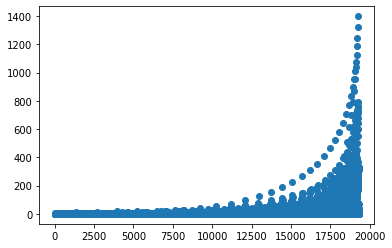

In [115]:
plt.scatter(range(len(y_train)), y_train)

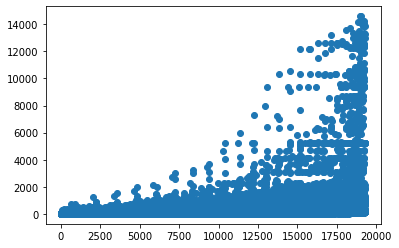

In [134]:
plt.scatter(range(len(y_train)), pred)